## Training CNN on CIFAR10 Dataset [1]

We begin with building a CNN architecture for image classification task on CIFAR10 dataset. 

In this first part of the tutorial, we will understand how to arrange the different architectural components of CNN network, defining the appropriate loss, training the network using backpropagation and finally testing it on the test data.To make data loading simple, we would use the torchvision package created as part of PyTorch which has data loaders for standard datasets such as ImageNet, CIFAR10, MNIST.
![CIFAR10](images/cifar10.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
import torchvision.transforms as transforms

#To schedule the learning rate
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
device = torch.device("cuda")
print("torch version: %s"%torch.__version__)

torch version: 0.4.0


In [2]:
DATA_ROOT = 'data'

# Hyper Parameters
num_epoch = 10               # train the training data n times, to save time, we just train 1 epoch
DOWNLOAD_CIFAR10 = True   # set to False if you have downloaded

#### Dataloader

For efficient training, we need to make sure that our code is efficient enough to send data from RAM to GPU and vice-versa. For some standard datasets like MNIST, CIFAR-10 etc., we already have some well structured dataloaders. In this tutorial, we will be using the CIFAR-10 dataloader.

For more you can visit the following links:

- Existing dataloaders - <https://pytorch.org/docs/stable/data.html>_
- How to write dataloaders for your custom dataset - <https://pytorch.org/tutorials/beginner/data_loading_tutorial.html>_

In [3]:
# We can perform different data augmentation
# techniques to increase the size of the dataset and make your model more robust
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# NOTE: PLEASE DON'T CHANGE batch_size and num_workers here. We have limited resources.
trainset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=DATA_ROOT, train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

# classes in the CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


Let us show some of the training images, for fun.

      ship       frog       ship       ship


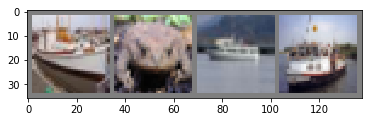

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Convolutional net architecture
![image](images/tLKYz.png)

### Define a Convolutional Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device)

### Define a loss function and an optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 on every epoch
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

### Train the network

Now, we will be training the network defined above on CIFAR-10 dataset.

We will train the network for num_epoch times (defined above)

- We fetch a batch of images and labels from dataloader
- We feed it to CNN network for forward pass
- Based on the output of forward pass, we calculate loss/error
- Then we calculate gradients of loss w.r.t. the parameters of the network
- Finally, we update the parameters based on the gradients using Gradient Descent algorithm

In [ ]:
for epoch in range(num_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    exp_lr_scheduler.step()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

### Test the network on the test datset

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

In [ ]:
# Quantitative Analysis
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
# Qualitative Analysis
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

# print images
imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))